In [1]:
### A Pluto.jl notebook ###
# v0.19.23

using Markdown
using InteractiveUtils


# PlantBiophysics.jl 3D global tree simulation

This Pluto notebook presents the computation of Fig. 7 from the scientific article. It displays leaf temperature on a 3D coffee tree simulated by PlantBiophysics.jl. Non-Pluto Julia script is also available (see [here](https://github.com/VEZY/PlantBiophysics-paper/blob/main/tutorials/Fig7_PlantBiophysics_3D_coffee_tree_noPluto.jl)).

## Importing the dependencies:

Loading the Julia packages:




In [2]:
begin
    using PlantBiophysics, PlantGeom, PlantMeteo, PlantSimEngine
    using CairoMakie
    using BenchmarkTools
    using FLoops
	using Downloads
    using Dates, DataFrames, CSV, Statistics
    using MultiScaleTreeGraph
    using PlutoUI
    nothing
end


## Reading data 
#### MTG file



In [3]:
mtg = read_opf(Downloads.download("https://raw.githubusercontent.com/VEZY/PlantBiophysics-paper/main/notebooks/upscaling/coffee.opf"))



/ 1: Individual
└─ / 2: Axis
   ├─ < 5: Metamer
   ├─ < 799: Metamer
   │  ├─ + 800: Axis
   │  │  ├─ < 806: Metamer
   │  │  │  └─ + 807: Axis
   │  │  │     ├─ / 808: Metamer
   │  │  │     ├─ < 810: Metamer
   │  │  │     ├─ < 814: Metamer
   │  │  │     │  ├─ + 816: Leaf
   │  │  │     │  └─ + 815: Leaf
   │  │  │     ├─ < 811: Metamer
   │  │  │     │  ├─ + 813: Leaf
   │  │  │     │  └─ + 812: Leaf
   │  │  │     ├─ < 809: Metamer
   │  │  │     └─ < 817: Metamer
   │  │  │        └─ + 818: Leaf
   │  │  ├─ < 939: Metamer
   │  │  │  ├─ + 940: Leaf
   │  │  │  └─ + 941: Leaf
   │  │  ├─ < 803: Metamer
   │  │  ├─ < 926: Metamer
   │  │  ├─ < 936: Metamer
   │  │  │  ├─ + 938: Leaf
   │  │  │  └─ + 937: Leaf
   │  │  ├─ < 899: Metamer
   │  │  ├─ < 842: Metamer
   │  │  │  ├─ + 869: Axis
   │  │  │  │  ├─ < 875: Metamer
…


#### Meteorological data



In [4]:
weather = PlantMeteo.read_weather(Downloads.download("https://raw.githubusercontent.com/VEZY/PlantBiophysics-paper/main/notebooks/upscaling/meteo.csv"),
    :temperature => :T,
    :relativeHumidity => (x -> x ./ 100) => :Rh,
    :wind => :Wind,
    :VPD => (x -> x ./ 100.0) => :VPD,
    :atmosphereCO2_ppm => :Cₐ,
    date_format=DateFormat("yyyy/mm/dd")
);




#### Models list



In [5]:
models = read_model(Downloads.download("https://raw.githubusercontent.com/VEZY/PlantBiophysics-paper/main/notebooks/upscaling/plant_coffee.yml"));

[ Info: Some variables must be initialized before simulation: (interception = (:Rᵢ,),) (see `to_initialize()`)
[ Info: Using default values for parameters [:aₛₕ, :aₛᵥ, :ε, :ΔT] in model Monteith


In [6]:
models["Leaf"]

╭──── Dependency graph ──────────────────────────────────────────────────╮
│  ╭──── interception ─────────────╮                                     │
│  │  ╭──── Main model ─────────╮  │                                     │
│  │  │  Process: interception  │  │                                     │
│  │  │  Model: Translucent     │  │                                     │
│  │  │  Dep: nothing           │  │                                     │
│  │  ╰─────────────────────────╯  │                                     │
│  ╰───────────────────────────────╯                                     │
│  ╭──── energy_balance ──────────────────────────────────────────────╮  │
│  │  ╭──── Main model ───────────╮                                   │  │
│  │  │  Process: energy_balance  │                                   │  │
│  │  │  Model: Monteith          │                                   │  │
│  │  │  Dep: nothing             │                                   │  │
│  │  ╰──────────────────

In [7]:
to_initialize(models["Leaf"])

(interception = (:Rᵢ,), photosynthesis = (:aPPFD,), energy_balance = (:Ra_SW_f, :d, :sky_fraction))

In [8]:
init_status!(models["Leaf"], Ra_SW_f = 300.0)


## Adding light interception data: incident radiation



In [9]:
mtg2 = transform(
    mtg,
    [:Ra_PAR_f, :Ra_NIR_f] => ((x, y) -> x + y * 1.2) => :Rᵢ, # This would be the incident radiation
    [:Ra_PAR_f, :Ra_NIR_f] => ((x, y) -> x + y) => :Rₛ,
    :Ra_PAR_f => (x -> x * 4.57) => :aPPFD,
    (x -> 0.3) => :d,
    ignore_nothing=true
)

/ 1: Individual
└─ / 2: Axis
   ├─ < 5: Metamer
   ├─ < 799: Metamer
   │  ├─ + 800: Axis
   │  │  ├─ < 806: Metamer
   │  │  │  └─ + 807: Axis
   │  │  │     ├─ / 808: Metamer
   │  │  │     ├─ < 810: Metamer
   │  │  │     ├─ < 814: Metamer
   │  │  │     │  ├─ + 816: Leaf
   │  │  │     │  └─ + 815: Leaf
   │  │  │     ├─ < 811: Metamer
   │  │  │     │  ├─ + 813: Leaf
   │  │  │     │  └─ + 812: Leaf
   │  │  │     ├─ < 809: Metamer
   │  │  │     └─ < 817: Metamer
   │  │  │        └─ + 818: Leaf
   │  │  ├─ < 939: Metamer
   │  │  │  ├─ + 940: Leaf
   │  │  │  └─ + 941: Leaf
   │  │  ├─ < 803: Metamer
   │  │  ├─ < 926: Metamer
   │  │  ├─ < 936: Metamer
   │  │  │  ├─ + 938: Leaf
   │  │  │  └─ + 937: Leaf
   │  │  ├─ < 899: Metamer
   │  │  ├─ < 842: Metamer
   │  │  │  ├─ + 869: Axis
   │  │  │  │  ├─ < 875: Metamer
…


!!! note
	We use `transform` instead of `transform!` here to make a copy of the mtg after modification because we shouldn't mutate objects in Pluto notebooks.




## Running the simulation



In [10]:
begin
    mtg_sim = deepcopy(mtg2)
    # Initialize the models inside the MTG:
    init_mtg_models!(mtg_sim, models, length(weather), verbose=false)
    # Make the simulation:
    run!(mtg_sim, weather)
end


## Benchmarking

Let's make a benchmark of the simulation on the whole coffee tree.



In [11]:
begin
    mtg_sim_bench = deepcopy(mtg2)
    # Initialize the models inside the MTG:
    init_mtg_models!(mtg_sim_bench, models, length(weather), verbose=false)
    # Make the simulation:
    times = @benchmark run!($mtg_sim, $weather)
end

BenchmarkTools.Trial: 16 samples with 1 evaluation.
 Range (min … max):  294.873 ms … 351.567 ms  ┊ GC (min … max): 2.61% … 4.54%
 Time  (median):     313.512 ms               ┊ GC (median):    4.80%
 Time  (mean ± σ):   317.894 ms ±  16.451 ms  ┊ GC (mean ± σ):  4.48% ± 0.79%

  ▃                █                                             
  █▁▁▁▁▁▇▁▁▇▁▁▁▁▇▁▁█▁▁▁▁▇▁▁▁▁▇▁▁▇▁▁▁▁▁▇▁▁▁▁▁▇▁▁▇▇▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  295 ms           Histogram: frequency by time          352 ms <

 Memory estimate: 82.59 MiB, allocs estimate: 1130880.

In [12]:
nleaves = length(findall(traverse(mtg_sim_bench, node -> node.MTG.symbol == "Leaf")))

2179

In [13]:
n_meteo_steps = length(weather)

3

In [14]:
total_time_s = sum(times.times) / length(times.times) * 1e-9

0.3178939979375


The simulation takes **$(round((total_time_s * 1e6) / (nleaves * n_meteo_steps), digits = 1)) μs** to run for each leaf, and **$(round(total_time_s, digits = 2)) s** for the whole plant on all time-steps.




!!! warning
	Benchmarking shouldn't be done in a Pluto notebook, and especially not on Github CI server that are **very** slow, but this gives an idea of how fast we can make a simulation, even on very low end hardware, and without parallelization.




## Plotting the result in 3D



Observable(

(27.048340136571866, 38.613736428598415))


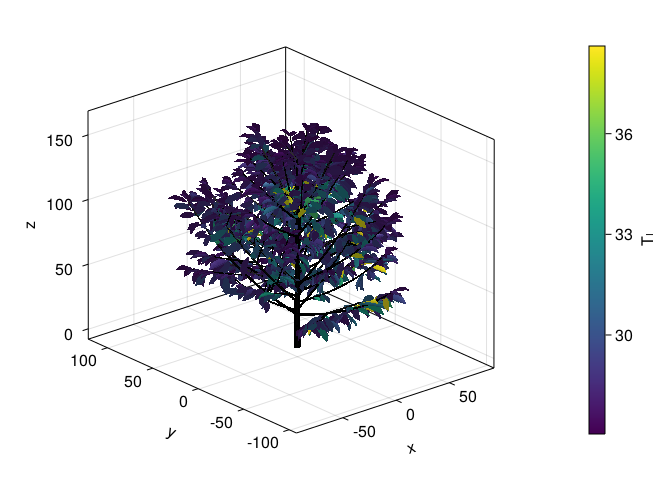

In [15]:
f = let
    f = Figure()
    ax = Axis3(f[1, 1], aspect=:data)
    p = viz!(ax, mtg_sim, color=:Tₗ, index=1)
    colorbar(f[1, 2], p)
    f
end

In [16]:
save("3d_coffee.png", f);